In [25]:
import numpy as np
import pandas as pd
import pandas as pd

df = pd.read_csv('faithful.txt', delim_whitespace=True)

print(df)

     eruptions  waiting
1        3.600       79
2        1.800       54
3        3.333       74
4        2.283       62
5        4.533       85
..         ...      ...
268      4.117       81
269      2.150       46
270      4.417       90
271      1.817       46
272      4.467       74

[272 rows x 2 columns]


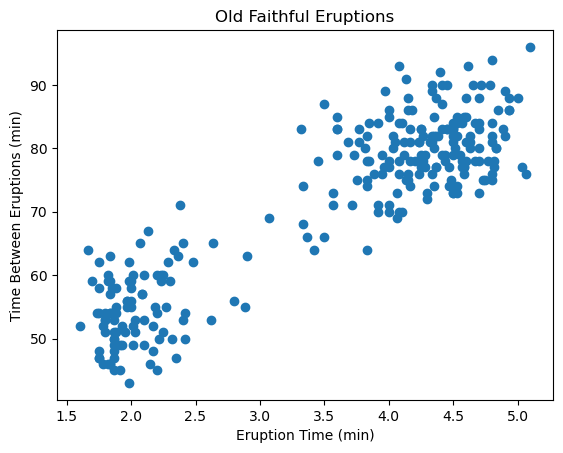

In [26]:
import matplotlib.pyplot as plt
plt.scatter(df['eruptions'], df['waiting'])
plt.title('Old Faithful Eruptions')
plt.xlabel('Eruption Time (min)')
plt.ylabel('Time Between Eruptions (min)')
plt.show()

In [185]:
import numpy as np

class GMM:
    def __init__(self, K=2, max_iterations=100, tol=1e-6):
        self.K = K  # Number of clusters
        self.max_iterations = max_iterations  # Max iterations for EM
        self.tol = tol  # Tolerance for convergence
        self.means = None
        self.covariances = None
        self.weights = None
        self.mean_trajectories = []

    def init_params(self, data_X):
        dim_N, dim_D = data_X.shape
        self.means = np.random.rand(self.K, dim_D) * (data_X.max(axis=0) - data_X.min(axis=0)) + data_X.min(axis=0)
        self.covariances = np.array([np.eye(dim_D) for _ in range(self.K)])
        self.weights = np.ones(self.K) / self.K
        self.mean_trajectories.append(self.means.copy())

    def gaussian_probability(self, X, mean, cov):
        dim_N, dim_D = X.shape
        diff = X - mean  
        exponent = -0.5 * np.sum(diff**2 / np.diag(cov), axis=1)
        return np.exp(exponent) / np.sqrt((2 * np.pi) ** dim_D * np.prod(np.diag(cov)))

    def em_algorithm(self, data_X):
        dim_N, dim_D = data_X.shape
        self.init_params(data_X)
        
        log_likelihood_old = -np.inf
        
        for iteration in range(self.max_iterations):
            # E-step: Calculate responsibilities
            responsibilities = np.zeros((dim_N, self.K))
            for k in range(self.K):
                responsibilities[:, k] = self.weights[k] * self.gaussian_probability(data_X, self.means[k], self.covariances[k])
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)

            # M-step: Update parameters
            Nk = responsibilities.sum(axis=0)  # Total responsibility for each cluster
            
            for k in range(self.K):
                self.means[k] = (responsibilities[:, k, np.newaxis] * data_X).sum(axis=0) / Nk[k]
                
                diff = data_X - self.means[k]
                self.covariances[k] = np.diag(np.sum(responsibilities[:, k, np.newaxis] * diff**2, axis=0) / Nk[k])
                
                # Update weights
                self.weights[k] = Nk[k] / dim_N
            self.mean_trajectories.append(self.means.copy())

            # Calculate log likelihood
            log_likelihood = np.sum(np.log(np.sum(self.weights[k] * self.gaussian_probability(data_X, self.means[k], self.covariances[k]) 
                                                   for k in range(self.K))))

            # Check for convergence
            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood
        
        return self.means, self.covariances, self.weights, iteration + 1


In [192]:
gmm = GMM()
means, covariances, weights, iterations = gmm.em_algorithm(df.to_numpy())

C:\Users\asus\AppData\Local\Temp\ipykernel_3848\1539586173.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(self.weights[k] * self.gaussian_probability(data_X, self.means[k], self.covariances[k])


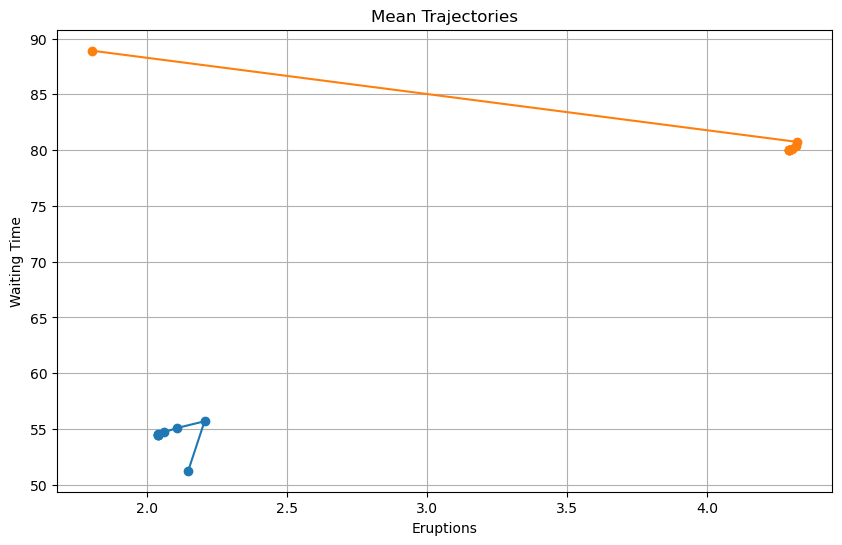

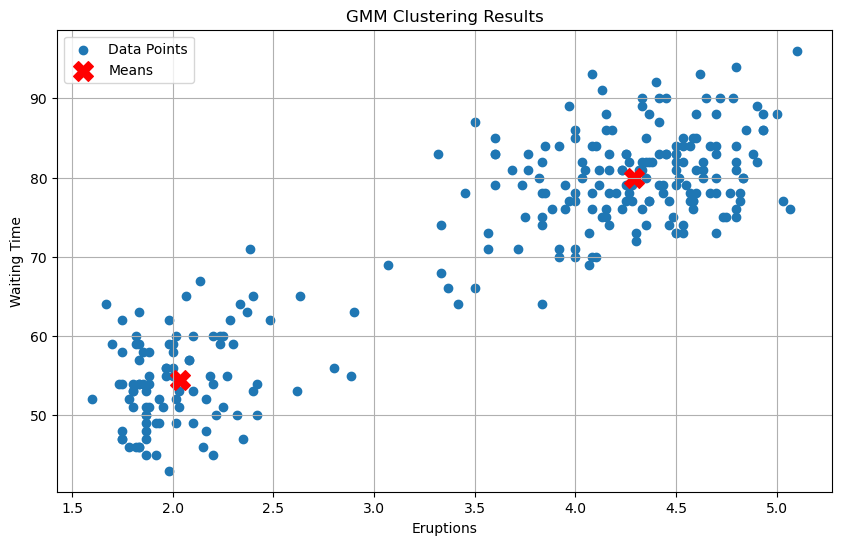

In [193]:
#Plot Mean trajectories
mean_trajectories = np.array(gmm.mean_trajectories)
plt.figure(figsize=(10, 6))
plt.plot(mean_trajectories[:, :, 0], mean_trajectories[:, :, 1], marker='o')
plt.xlabel('Eruptions')
plt.ylabel('Waiting Time')
plt.title('Mean Trajectories')
plt.grid()
plt.show()

# Plotting the data points with the learned means
plt.figure(figsize=(10, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], label='Data Points')
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], color='red', label='Means', marker='X', s=200)
plt.xlabel('Eruptions')
plt.ylabel('Waiting Time')
plt.title('GMM Clustering Results')
plt.legend()
plt.grid()
plt.show()

In [194]:
# Define a new GMM class that accepts initial parameters
class GMMWithInit(GMM):
    def __init__(self, K=2, max_iterations=100, tol=1e-6, initial_means=None, initial_covariances=None):
        super().__init__(K, max_iterations, tol)
        self.initial_means = initial_means
        self.initial_covariances = initial_covariances

    def init_params(self, data_X):
        if self.initial_means is not None and self.initial_covariances is not None:
            self.means = self.initial_means
            self.covariances = self.initial_covariances
        else:
            super().init_params(data_X)
        self.weights = np.ones(self.K) / self.K
        self.mean_trajectories.append(self.means.copy())

In [195]:
np.random.seed(42)

# Function to generate random initial guesses for means and covariances
def generate_initial_parameters(K, n_features):
    initial_means = np.random.rand(K, n_features)  # Random means
    initial_covariances = np.array([np.eye(n_features) for _ in range(K)])  # Identity matrices for covariances
    return initial_means, initial_covariances

C:\Users\asus\AppData\Local\Temp\ipykernel_3848\1539586173.py:37: RuntimeWarning: invalid value encountered in divide
  responsibilities /= responsibilities.sum(axis=1, keepdims=True)
C:\Users\asus\AppData\Local\Temp\ipykernel_3848\1539586173.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(self.weights[k] * self.gaussian_probability(data_X, self.means[k], self.covariances[k])


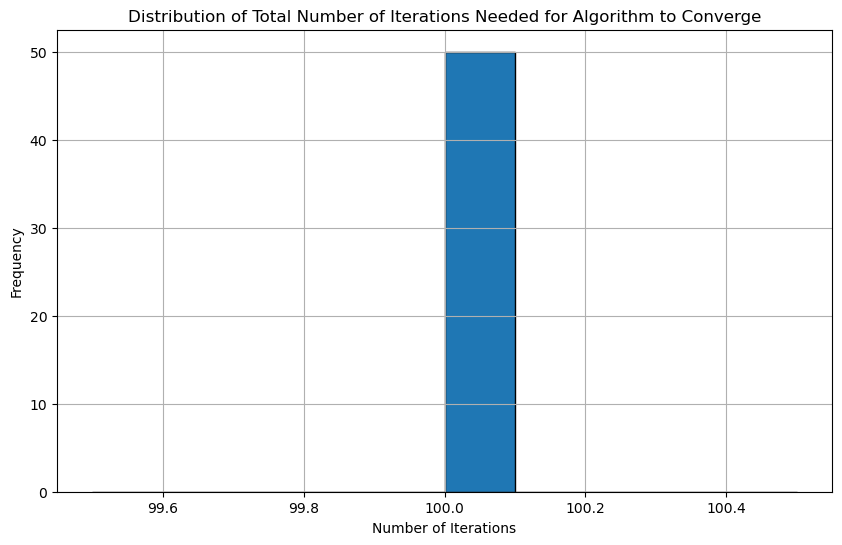

In [197]:

# Run the GMM algorithm 50 times with different initial parameter guesses
iterations_list = []
for i in range(50):
    initial_means, initial_covariances = generate_initial_parameters(2, df.shape[1])
    gmm = GMMWithInit(initial_means=initial_means, initial_covariances=initial_covariances)
    _, _, _, iterations = gmm.em_algorithm(df.to_numpy())
    iterations_list.append(iterations)

# Plot the distribution of the total number of iterations needed for the algorithm to converge
plt.figure(figsize=(10, 6))
plt.hist(iterations_list, bins=10, edgecolor='black')
plt.xlabel('Number of Iterations')
plt.ylabel('Frequency')
plt.title('Distribution of Total Number of Iterations Needed for Algorithm to Converge')
plt.grid()
plt.show()

In [198]:
from sklearn.cluster import KMeans

In [164]:
# Step 1: Run k-means clustering on the data
kmeans = KMeans(n_clusters=2, random_state=0).fit(df)
labels = kmeans.labels_

# Step 2: Initialize means and covariances using k-means results
initial_means = kmeans.cluster_centers_
initial_covariances = np.array([np.cov(df[labels == i].T) for i in range(2)])

gmm_with_init = GMMWithInit(initial_means=initial_means, initial_covariances=initial_covariances)
means_with_init, covariances_with_init, weights_with_init, iterations_with_init = gmm_with_init.em_algorithm(df.to_numpy(),params_done = 1)

print("Initial Means from K-Means:\n", initial_means)
print("Initial Covariances from K-Means:\n", initial_covariances)
print("GMM Means with K-Means Initialization:\n", means_with_init)
print("GMM Covariances with K-Means Initialization:\n", covariances_with_init)
print("Number of Iterations with K-Means Initialization:", iterations_with_init)

c:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Initial Means from K-Means:
 [[ 2.03791586 54.49295586]
 [ 4.29107065 79.98562334]]
Initial Covariances from K-Means:
 [[[ 0.07033691  0.        ]
  [ 0.         33.75586196]]

 [[ 0.16815092  0.        ]
  [ 0.         35.77332679]]]
GMM Means with K-Means Initialization:
 [[ 2.03791586 54.49295586]
 [ 4.29107065 79.98562334]]
GMM Covariances with K-Means Initialization:
 [[[ 0.07033691  0.        ]
  [ 0.         33.75586196]]

 [[ 0.16815092  0.        ]
  [ 0.         35.77332679]]]
Number of Iterations with K-Means Initialization: 5


C:\Users\asus\AppData\Local\Temp\ipykernel_3848\1539586173.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(self.weights[k] * self.gaussian_probability(data_X, self.means[k], self.covariances[k])
